In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from Models.selective_sequential import *
from Loss.triplet_regularized import *
from session import *
from LR_Schedule.cyclical import Cyclical
from LR_Schedule.cos_anneal import CosAnneal
from LR_Schedule.lr_find import lr_find
from callbacks import *
from validation import *
import Datasets.ImageData as ImageData
from Transforms.ImageTransforms import *
import util
from session import LossMeter, EvalModel
from Layers.flatten import Flatten
from torch.utils.tensorboard import SummaryWriter

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/drake/anaconda3/envs/.

In [2]:
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(0); torch.backends.cudnn.benchmark=True;

/home/drake/anaconda3/envs/.torch/lib/python3.7/site-packages/torch/cuda/__init__.py:135: UserWarning: 
    Found GPU0 GeForce GTX 770 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/train', download=True, train=True, transform=transform)
partial_trainset = torch.utils.data.dataset.Subset(trainset, np.arange(1000))

valset = datasets.MNIST('/media/drake/MX500/Datasets/mnist/test', download=True, train=False, transform=transform)
partial_valset = torch.utils.data.dataset.Subset(valset, np.arange(1000))

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

In [4]:
select = ['max1', 'act1', 'out']
model = SelectiveSequential(
    select,
    {'conv64': nn.Conv2d(1, 64, kernel_size=5, padding=2),
     'act64': nn.ReLU(True),
     
     'max1': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv192': nn.Conv2d(64, 192, kernel_size=5, padding=2),
     'act192': nn.ReLU(True),
    
     'max2': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'conv384': nn.Conv2d(192, 384, kernel_size=3, padding=1),
     'act384': nn.ReLU(True),
     
     'conv256a': nn.Conv2d(384, 256, kernel_size=3, padding=1),
     'act256a': nn.ReLU(True),
     
     'conv256b': nn.Conv2d(256, 256, kernel_size=3, padding=1),
     'act256b': nn.ReLU(True),
     
     'max3': nn.MaxPool2d(kernel_size=2, stride=2),
    
     'flatten': Flatten(),
     'fc1': nn.Linear(3 * 3 * 256, 512),
     'act1': nn.ReLU(True),
     'fc2': nn.Linear(512, 512),
     'act2': nn.ReLU(True),
     'out': nn.Linear(512, 10)})

In [5]:
criterion = TripletRegularizedMultiMarginLoss(.5, 1)
sess = Session(model, criterion, optim.Adam, 1e-4)

In [6]:
validator = EmbeddingSpaceValidator(valloader, len(select)-1, CustomOneHotAccuracy, 
                                    model_file="./triplet-reg.ckpt.tar")
lr_scheduler = CosAnneal(len(trainloader)*70, T_mult=1, lr_min=1e-6)
schedule = TrainingSchedule(trainloader, [lr_scheduler, validator])

In [7]:
sess.train(schedule, 70)

Validating: 100%|██████████| 157/157 [00:06<00:00, 23.55it/s]



val accuracy:  0.9871 
train loss:  2.2036  train BCE :  1.1645 
valid loss:  1.8041  valid BCE :  0.6112


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s]



val accuracy:  0.9917 
train loss:  1.642  train BCE :  0.5406 
valid loss:  1.3827  valid BCE :  0.4784


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.14it/s]



val accuracy:  0.9901 
train loss:  1.3513  train BCE :  0.4231 
valid loss:  1.1951  valid BCE :  0.3438


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.43it/s]



val accuracy:  0.9909 
train loss:  1.196  train BCE :  0.355 
valid loss:  1.0983  valid BCE :  0.3167


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.46it/s]



val accuracy:  0.9901 
train loss:  1.0611  train BCE :  0.2875 
valid loss:  1.018  valid BCE :  0.3292


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.49it/s]



val accuracy:  0.991 
train loss:  0.9859  train BCE :  0.2611 
valid loss:  0.9393  valid BCE :  0.1932


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.25it/s]



val accuracy:  0.9912 
train loss:  0.9185  train BCE :  0.2228 
valid loss:  0.8847  valid BCE :  0.2811


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.01it/s]



val accuracy:  0.9935 
train loss:  0.833  train BCE :  0.1887 
valid loss:  0.8414  valid BCE :  0.1372


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.88it/s]



val accuracy:  0.9802 
train loss:  0.8143  train BCE :  0.1743 
valid loss:  0.9076  valid BCE :  0.2716


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.18it/s]



val accuracy:  0.9882 
train loss:  0.75  train BCE :  0.1215 
valid loss:  0.8277  valid BCE :  0.1081


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.92it/s]



val accuracy:  0.9943 
train loss:  0.7161  train BCE :  0.0992 
valid loss:  0.7506  valid BCE :  0.1074


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.11it/s]



val accuracy:  0.9878 
train loss:  0.7054  train BCE :  0.1013 
valid loss:  0.7894  valid BCE :  0.1264


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]



val accuracy:  0.9909 
train loss:  0.6906  train BCE :  0.1069 
valid loss:  0.7519  valid BCE :  0.0966


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.56it/s]



val accuracy:  0.9927 
train loss:  0.6785  train BCE :  0.0969 
valid loss:  0.7447  valid BCE :  0.0903


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.04it/s]



val accuracy:  0.9901 
train loss:  0.6231  train BCE :  0.0826 
valid loss:  0.7253  valid BCE :  0.118


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.32it/s]



val accuracy:  0.9936 
train loss:  0.6158  train BCE :  0.0719 
valid loss:  0.6965  valid BCE :  0.0696


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.69it/s]



val accuracy:  0.9937 
train loss:  0.5998  train BCE :  0.0642 
valid loss:  0.687  valid BCE :  0.0892


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.83it/s]



val accuracy:  0.9898 
train loss:  0.5937  train BCE :  0.0588 
valid loss:  0.7014  valid BCE :  0.0807


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.80it/s]



val accuracy:  0.994 
train loss:  0.5858  train BCE :  0.0424 
valid loss:  0.6738  valid BCE :  0.0595


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.98it/s]



val accuracy:  0.993 
train loss:  0.5808  train BCE :  0.0438 
valid loss:  0.6662  valid BCE :  0.0636


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.61it/s]



val accuracy:  0.9922 
train loss:  0.5724  train BCE :  0.0363 
valid loss:  0.6747  valid BCE :  0.0537


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.22it/s]



val accuracy:  0.9924 
train loss:  0.5676  train BCE :  0.0276 
valid loss:  0.679  valid BCE :  0.0481


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.29it/s]



val accuracy:  0.993 
train loss:  0.5711  train BCE :  0.0312 
valid loss:  0.6685  valid BCE :  0.0451


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.12it/s]



val accuracy:  0.9886 
train loss:  0.5738  train BCE :  0.0305 
valid loss:  0.7149  valid BCE :  0.0617


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.15it/s]



val accuracy:  0.9928 
train loss:  0.5666  train BCE :  0.0293 
valid loss:  0.655  valid BCE :  0.0444


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.86it/s]



val accuracy:  0.992 
train loss:  0.5545  train BCE :  0.0275 
valid loss:  0.6665  valid BCE :  0.0415


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.03it/s]



val accuracy:  0.9919 
train loss:  0.5491  train BCE :  0.0248 
valid loss:  0.658  valid BCE :  0.0461


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.05it/s]



val accuracy:  0.9926 
train loss:  0.5486  train BCE :  0.0297 
valid loss:  0.6519  valid BCE :  0.0457


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.15it/s]



val accuracy:  0.9932 
train loss:  0.5483  train BCE :  0.0341 
valid loss:  0.6559  valid BCE :  0.0445


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.11it/s]



val accuracy:  0.9924 
train loss:  0.5421  train BCE :  0.0286 
valid loss:  0.6439  valid BCE :  0.0505


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.55it/s]



val accuracy:  0.9882 
train loss:  0.5444  train BCE :  0.0219 
valid loss:  0.693  valid BCE :  0.0577


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.07it/s]



val accuracy:  0.9929 
train loss:  0.5409  train BCE :  0.0206 
valid loss:  0.6527  valid BCE :  0.0387


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.29it/s]



val accuracy:  0.9918 
train loss:  0.5382  train BCE :  0.0204 
valid loss:  0.6508  valid BCE :  0.0372


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.11it/s]



val accuracy:  0.9924 
train loss:  0.536  train BCE :  0.02 
valid loss:  0.655  valid BCE :  0.0378


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.35it/s]



val accuracy:  0.9927 
train loss:  0.5343  train BCE :  0.0204 
valid loss:  0.6567  valid BCE :  0.0469


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.10it/s]



val accuracy:  0.993 
train loss:  0.5327  train BCE :  0.0205 
valid loss:  0.6417  valid BCE :  0.0403


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.04it/s]



val accuracy:  0.992 
train loss:  0.5349  train BCE :  0.0227 
valid loss:  0.6689  valid BCE :  0.0439


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.38it/s]



val accuracy:  0.9914 
train loss:  0.5329  train BCE :  0.0203 
valid loss:  0.6602  valid BCE :  0.0454


Validating: 100%|██████████| 157/157 [00:06<00:00, 25.00it/s]



val accuracy:  0.9919 
train loss:  0.5306  train BCE :  0.0202 
valid loss:  0.6576  valid BCE :  0.0435


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.54it/s]



val accuracy:  0.9922 
train loss:  0.5302  train BCE :  0.0171 
valid loss:  0.6593  valid BCE :  0.0455


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.36it/s]



val accuracy:  0.9924 
train loss:  0.5274  train BCE :  0.0212 
valid loss:  0.6501  valid BCE :  0.0484


Validating: 100%|██████████| 157/157 [00:06<00:00, 24.30it/s]



val accuracy:  0.9887 
train loss:  0.5343  train BCE :  0.0246 
valid loss:  0.6937  valid BCE :  0.0476


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.57it/s]



val accuracy:  0.9897 
train loss:  0.527  train BCE :  0.0171 
valid loss:  0.6856  valid BCE :  0.0594


Validating: 100%|██████████| 157/157 [00:07<00:00, 21.42it/s]



val accuracy:  0.9927 
train loss:  0.5247  train BCE :  0.0214 
valid loss:  0.6482  valid BCE :  0.0432


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.28it/s]



val accuracy:  0.9925 
train loss:  0.5252  train BCE :  0.0187 
valid loss:  0.6533  valid BCE :  0.037


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.69it/s]



val accuracy:  0.9928 
train loss:  0.5243  train BCE :  0.0178 
valid loss:  0.6481  valid BCE :  0.0427


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.85it/s]



val accuracy:  0.9931 
train loss:  0.5227  train BCE :  0.0238 
valid loss:  0.6418  valid BCE :  0.0443


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.76it/s]



val accuracy:  0.993 
train loss:  0.523  train BCE :  0.0242 
valid loss:  0.6392  valid BCE :  0.0465


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.73it/s]



val accuracy:  0.9924 
train loss:  0.5227  train BCE :  0.0273 
valid loss:  0.6482  valid BCE :  0.0486


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.79it/s]



val accuracy:  0.9923 
train loss:  0.5216  train BCE :  0.0251 
valid loss:  0.6488  valid BCE :  0.0483


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.64it/s]



val accuracy:  0.9923 
train loss:  0.5209  train BCE :  0.0264 
valid loss:  0.6456  valid BCE :  0.0495


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.77it/s]



val accuracy:  0.993 
train loss:  0.5203  train BCE :  0.0265 
valid loss:  0.6404  valid BCE :  0.0501


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.76it/s]



val accuracy:  0.9932 
train loss:  0.5199  train BCE :  0.0285 
valid loss:  0.643  valid BCE :  0.0522


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.77it/s]



val accuracy:  0.9927 
train loss:  0.52  train BCE :  0.0303 
valid loss:  0.6473  valid BCE :  0.055


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.59it/s]



val accuracy:  0.9922 
train loss:  0.5189  train BCE :  0.0317 
valid loss:  0.6396  valid BCE :  0.0566


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.78it/s]



val accuracy:  0.9925 
train loss:  0.5199  train BCE :  0.0344 
valid loss:  0.6407  valid BCE :  0.0555


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.70it/s]



val accuracy:  0.9924 
train loss:  0.519  train BCE :  0.0345 
valid loss:  0.645  valid BCE :  0.061


Validating: 100%|██████████| 157/157 [00:07<00:00, 22.29it/s]



val accuracy:  0.9922 
train loss:  0.5184  train BCE :  0.0349 
valid loss:  0.6423  valid BCE :  0.0569


Validating: 100%|██████████| 157/157 [00:07<00:00, 21.94it/s]



val accuracy:  0.9926 
train loss:  0.5181  train BCE :  0.0373 
valid loss:  0.6438  valid BCE :  0.0606


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.43it/s]



val accuracy:  0.9929 
train loss:  0.5181  train BCE :  0.0388 
valid loss:  0.6432  valid BCE :  0.0617


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.31it/s]



val accuracy:  0.9928 
train loss:  0.5175  train BCE :  0.0391 
valid loss:  0.6424  valid BCE :  0.0647


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.52it/s]



val accuracy:  0.9926 
train loss:  0.5181  train BCE :  0.0411 
valid loss:  0.6457  valid BCE :  0.0655


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.74it/s]



val accuracy:  0.993 
train loss:  0.5172  train BCE :  0.0418 
valid loss:  0.6394  valid BCE :  0.0643


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.58it/s]



val accuracy:  0.9927 
train loss:  0.5171  train BCE :  0.0422 
valid loss:  0.643  valid BCE :  0.0669


Validating: 100%|██████████| 157/157 [00:07<00:00, 19.94it/s]



val accuracy:  0.9925 
train loss:  0.517  train BCE :  0.0428 
valid loss:  0.6411  valid BCE :  0.0668


Validating: 100%|██████████| 157/157 [00:07<00:00, 20.52it/s]



val accuracy:  0.993 
train loss:  0.517  train BCE :  0.0424 
valid loss:  0.6419  valid BCE :  0.0679


Validating: 100%|██████████| 157/157 [00:06<00:00, 23.06it/s]



val accuracy:  0.9929 
train loss:  0.5167  train BCE :  0.044 
valid loss:  0.6418  valid BCE :  0.0692


Validating: 100%|██████████| 157/157 [00:06<00:00, 22.91it/s]



val accuracy:  0.9928 
train loss:  0.5169  train BCE :  0.0451 
valid loss:  0.6406  valid BCE :  0.0682


Validating: 100%|██████████| 157/157 [00:07<00:00, 20.98it/s]



val accuracy:  0.9928 
train loss:  0.5171  train BCE :  0.0451 
valid loss:  0.6413  valid BCE :  0.0686


Validating: 100%|██████████| 157/157 [00:07<00:00, 21.59it/s]



val accuracy:  0.9929 
train loss:  0.5168  train BCE :  0.0452 
valid loss:  0.6406  valid BCE :  0.0697



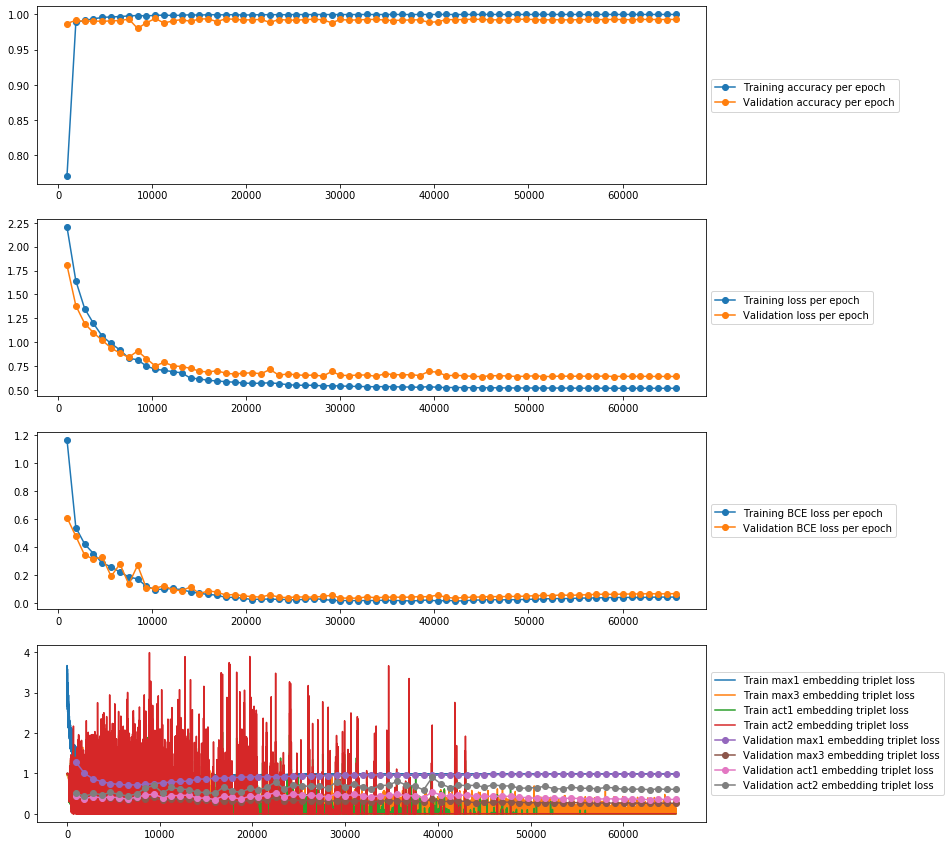

In [8]:
validator.plot()

In [13]:
sess.load("./triplet-reg.ckpt.tar")

In [14]:
total_valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
total_validator = EmbeddingSpaceValidator(total_valloader, len(select)-1, CustomOneHotAccuracy)

total_validator.run(sess)

Validating: 100%|██████████| 157/157 [00:04<00:00, 34.88it/s]


In [15]:
np.max(total_validator.val_accuracies), "Best accuracy without reg"

(0.9929, 'Best accuracy without reg')

In [16]:
visualization_set = torch.utils.data.dataset.Subset(valset, np.arange(500))
dataloader = torch.utils.data.DataLoader(visualization_set, batch_size=64, shuffle=False)

tensorboard_embeddings(model, ['max1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_tripletreg')

tensorboard_embeddings(model, ['max2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_tripletreg')

tensorboard_embeddings(model, ['max3'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_tripletreg')

tensorboard_embeddings(model, ['act1'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_tripletreg')

tensorboard_embeddings(model, ['act2'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_tripletreg')

tensorboard_embeddings(model, ['out'], 
                       dataloader, 
                       valset.targets[:500], 
                       1.0 - valset.data[:500].reshape(-1, 1, 28, 28) / 255.0, 
                       './mnist_tripletreg')